In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from xgboost import XGBClassifier
import yfinance as yf
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

# Request data
Request history data from Yahoo Finance.

In [2]:
period = "max"
data = "AMZN"

# select a stock
data = yf.Ticker("AMZN")
# return history data of the stock as dataframe
df = data.history(period=period)
# df.head()
# df.describe()
# df.info()
# check if any entry is none/null/NaN
# df.isnull().sum()

# Preprocessing
Clean and prep data for training. Check for outliers and non-informative features.

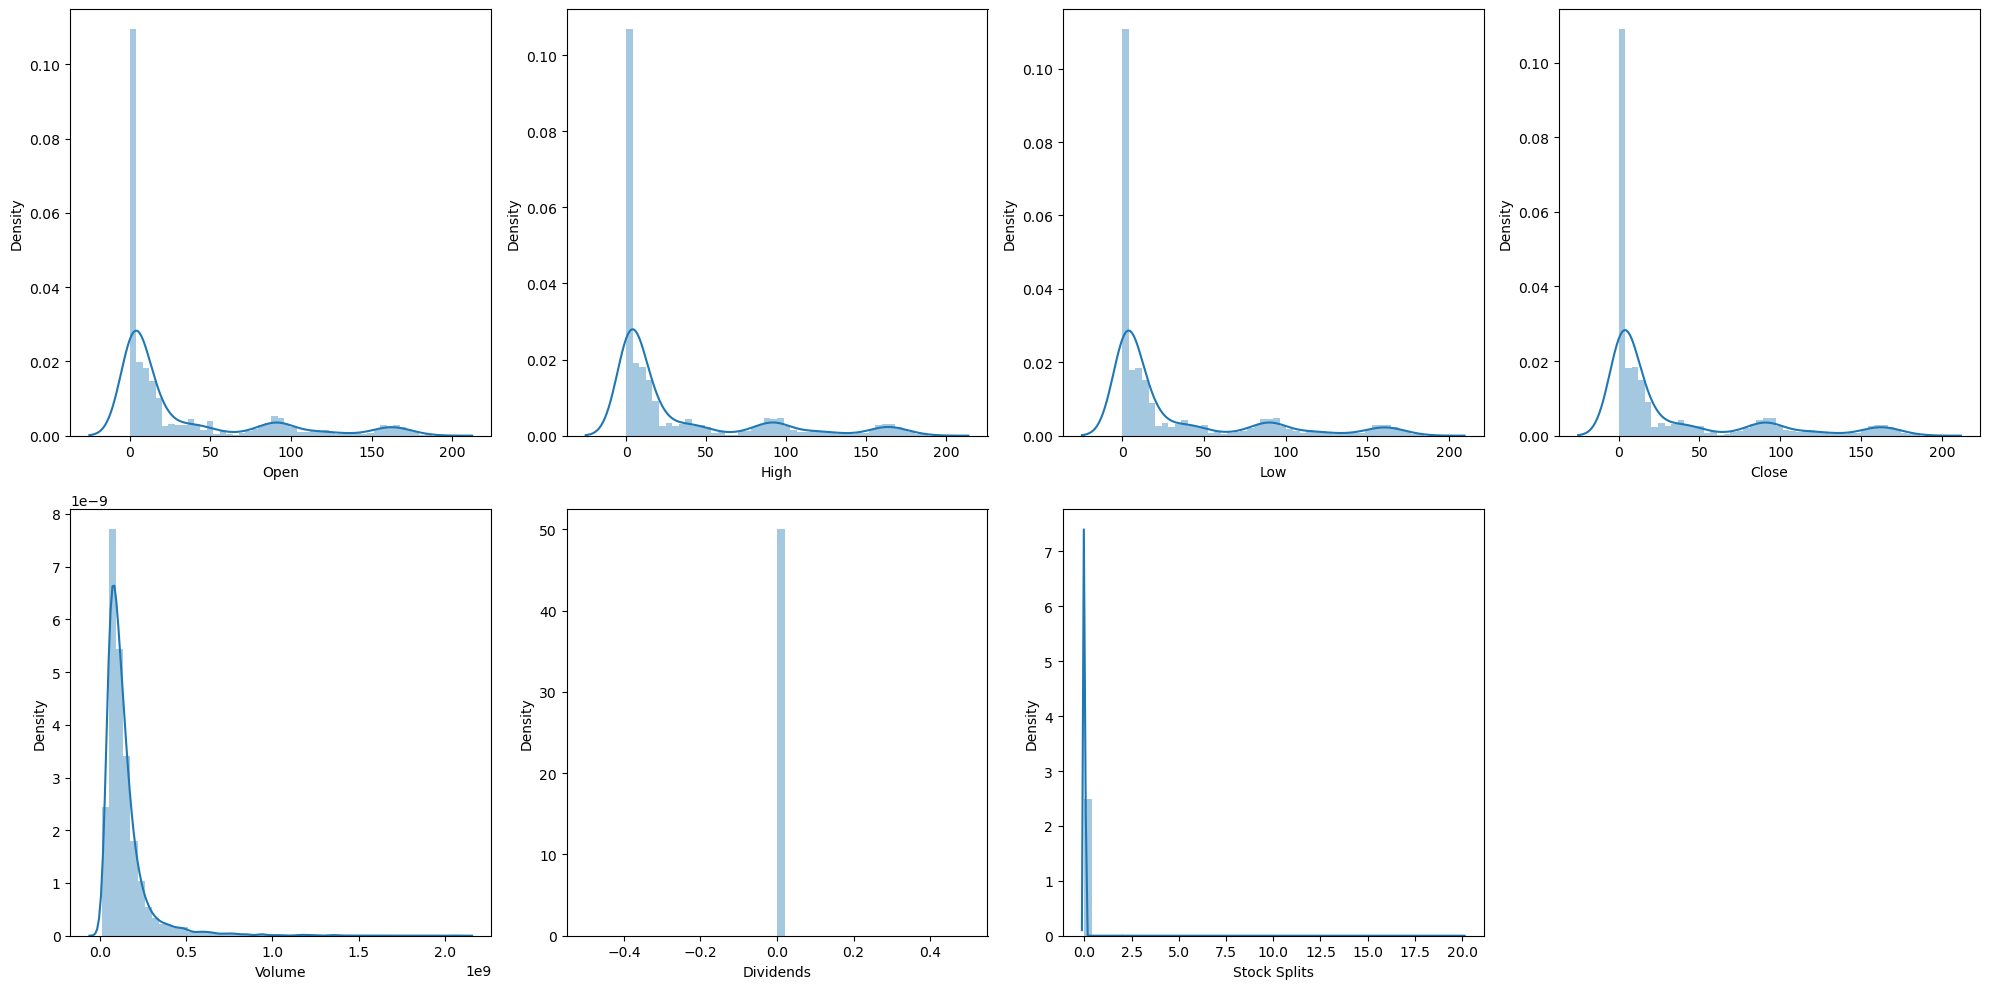

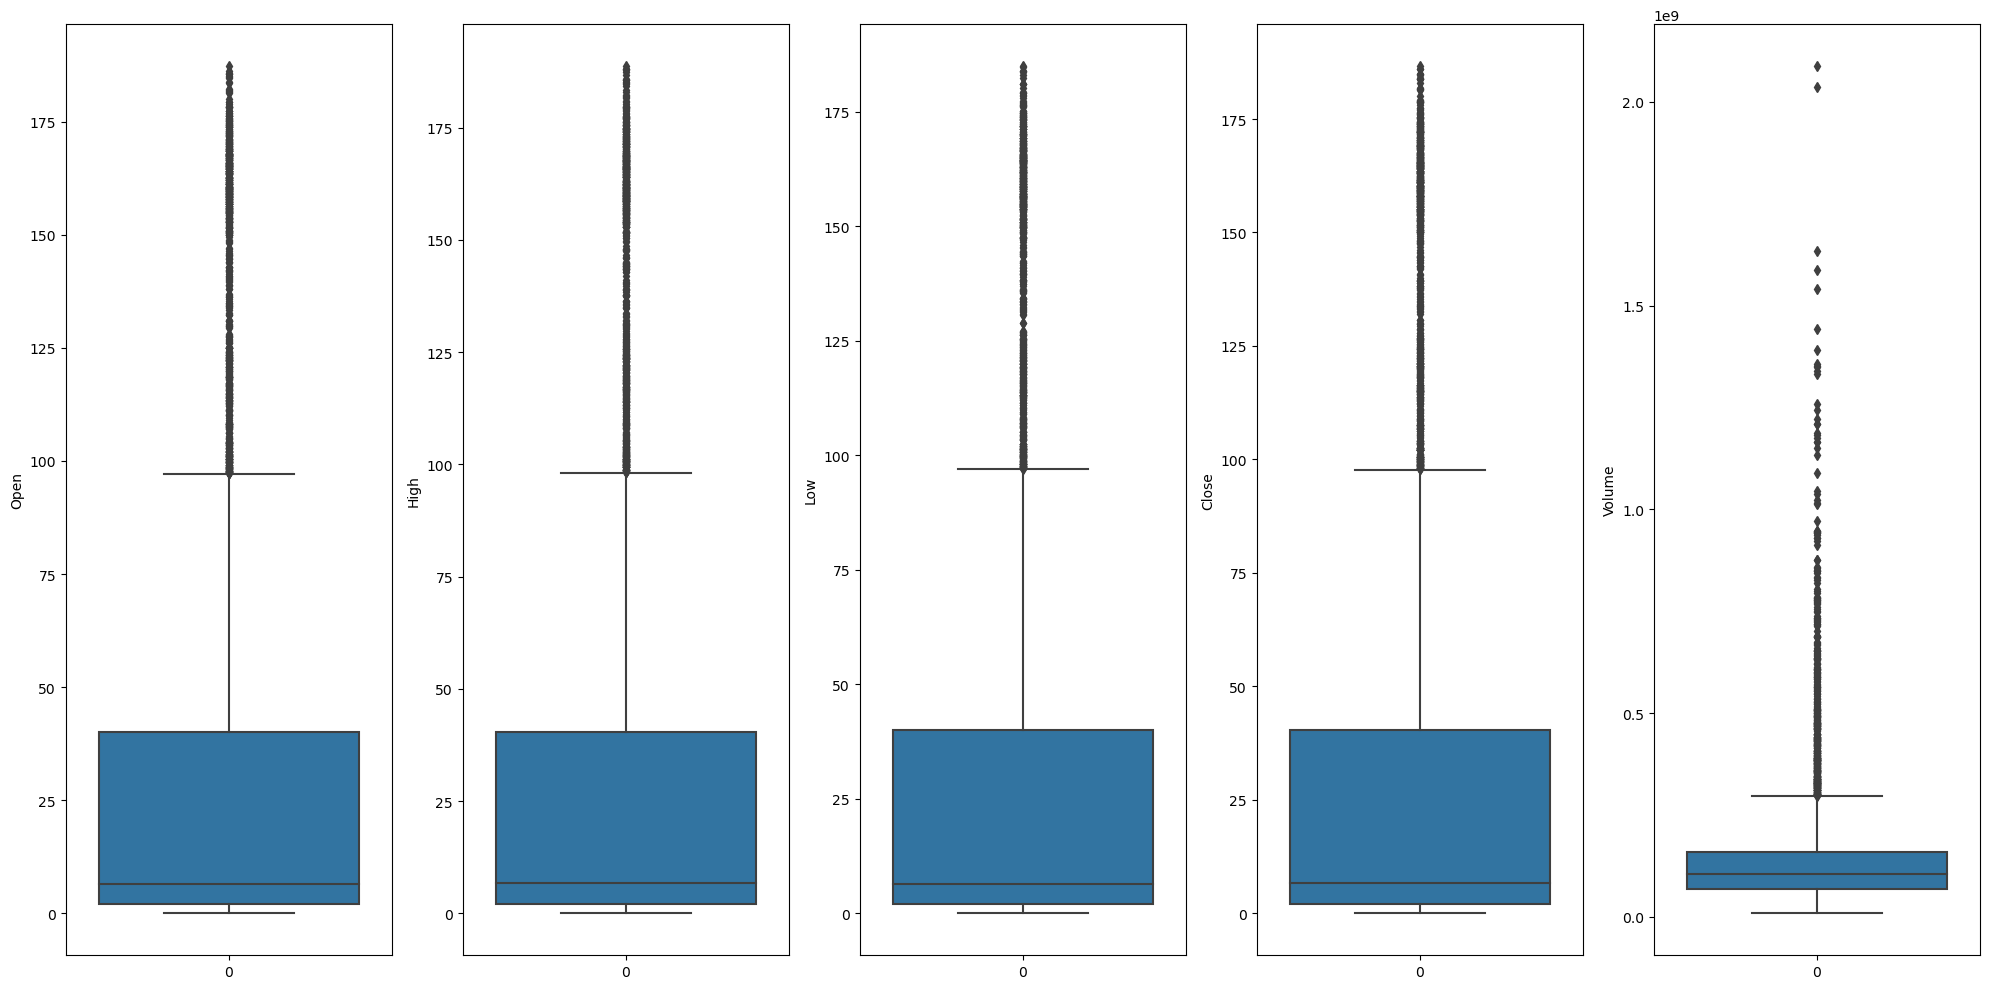

In [3]:
# plot data points of features
plt.subplots(figsize=(20, 10))
for i, col in enumerate(df.columns):
    plt.subplot(2,math.ceil(len(df.columns)/2),i+1)
    sns.distplot(df[col])
    plt.tight_layout()
plt.show()

# remove dividend and stock split as there's no useful information
df = df.drop(['Dividends', 'Stock Splits'], axis=1)
# check for outliers
plt.subplots(figsize=(20,10))
for i, col in enumerate(df.columns):
    plt.subplot(1,len(df.columns),i+1)
    ax = sns.boxplot(data=df[col])
    ax.set_ylabel(df.columns[i])
    plt.tight_layout()
plt.show()

# Feature Engineering

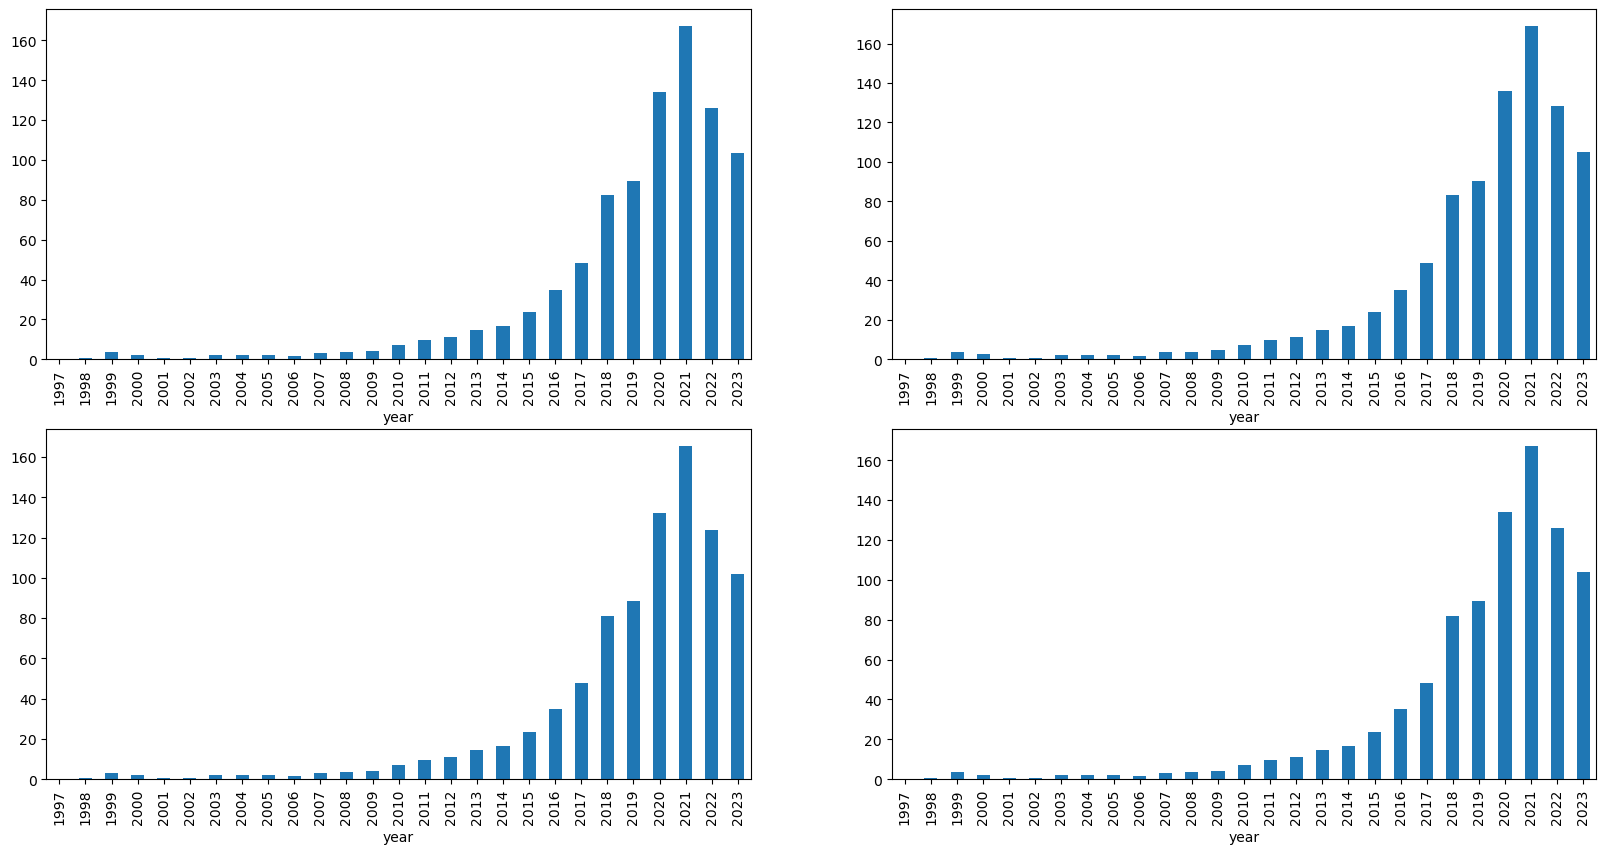

,Open,High,Low,Close,Volume,day,month,year
is_quarter_end,,,,,,,,
0,32.231255,32.630566,31.807362,32.228857,1.468881e+08,15.732521,6.091536,2009.950322
1,32.255782,32.626891,31.827063,32.229564,1.322116e+08,15.727355,7.427670,2009.848580


In [4]:
# df return date as index
# save only the date since timestamp is the same for all logs
df.insert(0, "Date", df.index.date)
# set index to a list of integer from 0 to length of df
df.index = [i for i in range(len(df.index))]
# convert date from object to datetime dtype
df["Date"] = pd.to_datetime(df["Date"])

# save the dates individually or could use sin/cos to represent cyclicity
# https://www.tensorflow.org/tutorials/structured_data/time_series
# https://towardsdatascience.com/make-your-machine-learning-model-work-better-with-datetime-features-eb21de397fe8
df["day"] = df["Date"].dt.day
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year

# quarterly results posted by company can greatly affect stock prices
# depend on how well the company does, price changes
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)

# visualize price changes over the year
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2,2,i+1)
    data_grouped[col].plot.bar()
plt.show()

# deterine how price changes during quarter end vs. non
df.groupby('is_quarter_end').mean()

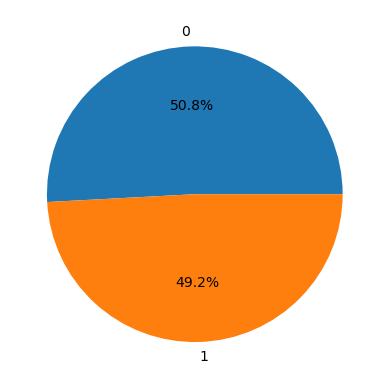

In [5]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
# buy low
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

# check for equal distribution of classes
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

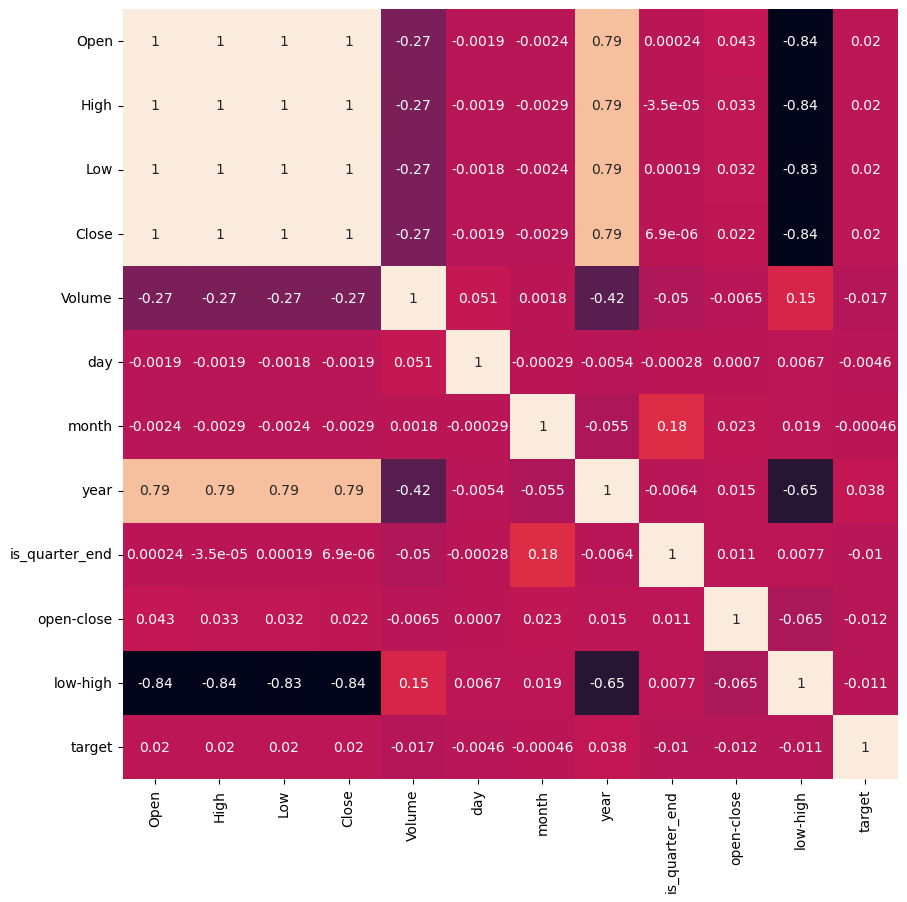

In [6]:
# Check for highly correlated features as it is redundant
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cbar=False)
plt.show()
# Remove one or the other feature that are highly correlated

# Data Splitting and Normalization
Split dataset into trainning and testing set prevent overfitting that is shown by abnormnally high accuracy or performance.  
Normalization/standardization help model learn faster and better as shown [here](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02).   
*NOTE: dataset should be split before normalized/standardized. Normalized/standardized the whole dataset cause data leakage from dataset into train/test. Meaning it include trainning data into testing data, or vice-versa.*

In [7]:
# Split dataset into train/test
SEED = 0
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

x_tr, x_ts, y_tr, y_ts = train_test_split(features, target, test_size=0.1, random_state=SEED)

In [8]:
# Standardized dataset
# prefer to standardized my dataset because of outliers.
# outliers can be separate to be trained invidiually since there are 2 different section based on box plot.
scaler = StandardScaler()
# standardized each dataset individually
x_tr = scaler.fit_transform(x_tr)
x_ts = scaler.fit_transform(x_ts)

# Train Models
For different scoring metrics in k-fold cross validation, refer to [this link](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

LogisticRegression() Accuracy: 0.5385244048880413
SVC(kernel='poly', probability=True) Accuracy: 0.521516564243837
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) Accuracy: 0.4857148407148407


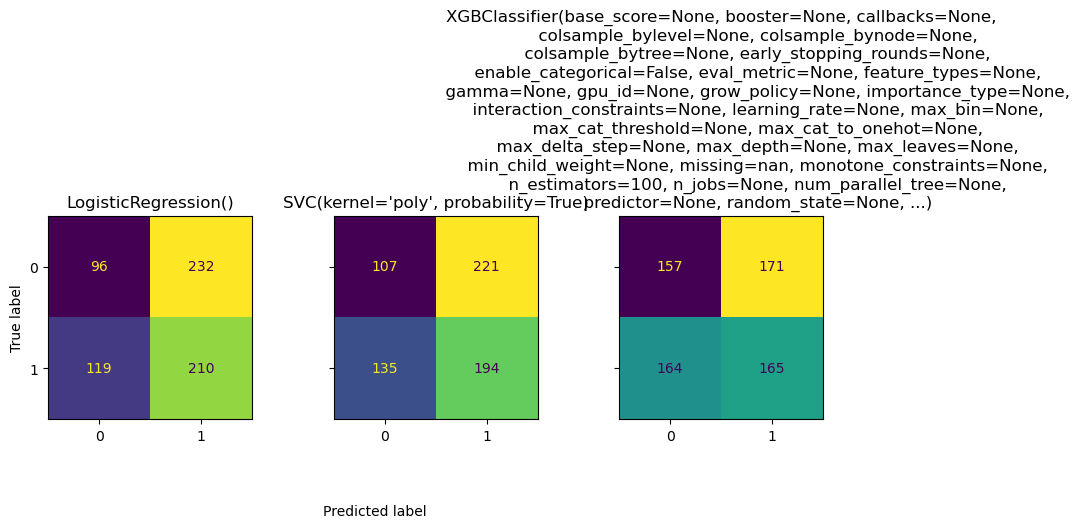

In [9]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey='row')
for i, m in enumerate(models):
    m.fit(x_tr, y_tr)
    # use 5-fold cross-validation to determine the performance as it prevent overfitting
    scores = cross_val_score(m, x_ts, y_ts, cv=5, scoring='roc_auc')
    print(f"{m} Accuracy: {scores.mean()}")
    
    # confusion matrix compare our model prediction with target value on new data
    # predict new data
    y_pred = m.predict(x_ts)
    # compare predictions with known labels of new data
    cf_matrix = confusion_matrix(y_ts, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    # customized the way cm are presented
    disp.plot(ax=axes[i])
    disp.ax_.set_title(m)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

fig.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()